# Instalação de Módulos Importantes

In [1]:
#pip install openrouteservice folium 

# Imports

In [194]:
import pandas as pd
import numpy as np
import time
import json
from itertools import permutations

import matplotlib.pyplot as plt

import openrouteservice

# Config

Entre no portal da `ORS` `https://openrouteservice.org/dev` para criar seu `login` e requisitar um `token` para utilização da `API`.<br>
<b>`É totalmente grátis!`</b>

Crie um arquivo chamado `_config.hide` com o formato `json` como abaixo.<br>
<b>`Tenha certeza que você e somente você tenha acesso a este token!`</b>

```json
{
    "ors": {
        "_api_token_code": "seu-token-code"
   }
}
```

In [196]:
with open('_config.hide') as _opened_config_file:
    _config_file = json.load(_opened_config_file)["ors"]

## API Connection
Agora você estará conectado ao serviço da `ORS` usando o token `api-token-code`.<br>
<b>`Tenha certeza que você e somente você tenha acesso a este token!`</b>

In [198]:
_api_token_code = _config_file["_api_token_code"]

_client = openrouteservice.Client(key=_api_token_code)

## Carregando o arquivo do IBGE
Carregando um `DataFrame` com a biblioteca `Pandas` a partir de um arquivo `.csv` extraído do portal do `IBGE` contendo os de todos os `municípios` do Brasil juntamente com os seus respectivos dados de `latitude` e `longitude` do centro da cidade.

In [199]:
_df_ibge = pd.read_csv("dados/ibge_municipios.csv", sep=";")
#_df_ibge.to_csv("dados/ibge_municipios.csv", sep=";", index=False)

_df_ibge["long_lat"] = _df_ibge["long"].apply(str) + " " + _df_ibge["lat"].apply(str)

_df_ibge.head()

,ibge,microrregiao,mesorregiao,municipio,uf,lat,long,long_lat
0,5200050,GOIÂNIA,CENTRO GOIANO,ABADIA DE GOIÁS,GO,-16.75730,-49.4412,-49.4412 -16.7573
1,3100104,PATROCÍNIO,TRIÂNGULO MINEIRO/ALTO PARANAÍBA,ABADIA DOS DOURADOS,MG,-18.48310,-47.3916,-47.3916 -18.4831
2,5200100,ENTORNO DE BRASÍLIA,LESTE GOIANO,ABADIÂNIA,GO,-16.19700,-48.7057,-48.7057 -16.197
3,3100203,TRÊS MARIAS,CENTRAL MINEIRA,ABAETÉ,MG,-19.15510,-45.4444,-45.4444 -19.1551
4,1500107,CAMETÁ,NORDESTE PARAENSE,ABAETETUBA,PA,-1.72183,-48.8788,-48.8788 -1.72183


## Filtrando somente o Centro-Sul Cearense
Para facilitar a demonstração do recurso, abaixo filtramos `apenas` os municípios da `mesorregião` Centro-Sul do Ceará.

In [66]:
_df_centro_sul_cearense = _df_ibge[
    (_df_ibge.uf=="CE") &
    (_df_ibge.mesorregiao=="CENTRO-SUL CEARENSE")
].sort_values(by=["lat"])

_df_centro_sul_cearense.head()

,ibge,microrregiao,mesorregiao,municipio,uf,lat,long,long_lat
2223,2305704,LAVRAS DA MANGABEIRA,CENTRO-SUL CEARENSE,IPAUMIRIM,CE,-6.78265,-38.7179,-38.7179 -6.78265
5447,2314003,VÁRZEA ALEGRE,CENTRO-SUL CEARENSE,VÁRZEA ALEGRE,CE,-6.78264,-39.2942,-39.2942 -6.78264
256,2300804,VÁRZEA ALEGRE,CENTRO-SUL CEARENSE,ANTONINA DO NORTE,CE,-6.76919,-39.9870,-39.987 -6.76919
2755,2307502,LAVRAS DA MANGABEIRA,CENTRO-SUL CEARENSE,LAVRAS DA MANGABEIRA,CE,-6.74480,-38.9706,-38.9706 -6.7448
460,2301802,LAVRAS DA MANGABEIRA,CENTRO-SUL CEARENSE,BAIXIO,CE,-6.71945,-38.7134,-38.7134 -6.71945


## Requisitando as rotas entre os Municípios do Centro-Sul Cearense

### Criando a combinação única de todos os municípios
Abaixo serão listadas todas as `combinações de municípios`, `evitando` a `duplicidade` provocada pelo processo de `permutação`. Em outras palavras, a `rota` é analisada `apenas` na `ida` em vez de `ida e vinda`.

In [ ]:
_longs_lats_centro_sul_cearense = list(_df_centro_sul_cearense["long_lat"])
_longs_lats_centro_sul_cearense_combinados = [(tuple(_coord[0].split()), tuple(_coord[1].split())) for _coord in _longs_lats_centro_sul_cearense_combinados]

### Buscando todos os dados de rota
Agora todas as `rotas` serão `calculadas` a partir do serviço da `ORS`. É necessário `aguardar 5 segundos` para evitar `onerar` a `API`.

In [ ]:
_dict_coord_dist_dur_rota = {}

for _coords in _longs_lats_centro_sul_cearense_combinados:
    time.sleep(5)
    _res = _client.directions(_coords)
    
    _distancia = _res["routes"][0]["summary"]["distance"]
    _duracao   = _res["routes"][0]["summary"]["duration"]
    _rota = pd.DataFrame(openrouteservice.convert.decode_polyline(_res['routes'][0]['geometry'])["coordinates"], columns=["long", "lat"])
    
    _dict_coord_dist_dur_rota[_coords] = {
        "metros":   _distancia,
        "segundos": _duracao,
        "rota":     _rota
    }

## Criando as labels com os nomes dos municípios para plotar no mapa

In [166]:
_labels_to_plot = _df_centro_sul_cearense.set_index([
  "long",
  "lat"
]).municipio.to_dict()

## Plotando os dados analisados no mapa
Será plotado um `gráfico de dispersão` análogo a um `mapa` contendo os `municípios` (pontos) e as `rotas` entre eles (linhas em cinza claro).

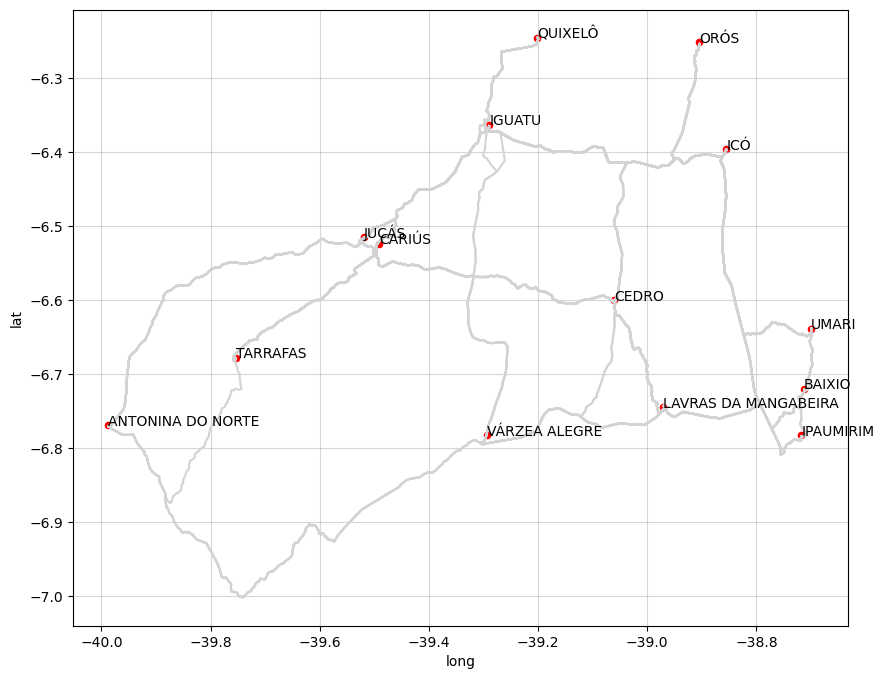

In [189]:
# initialize an axis
fig, ax = plt.subplots(figsize=(10, 8))
# plot map on axis

#plotar centro sul cearense
_df_centro_sul_cearense.plot(
    x="long", 
    y="lat", 
    kind="scatter", 
    c="red",
    s=20,
    colormap="YlOrRd", 
    ax=ax
)

#plotar nomes das cidades
for _long_lat in _labels_to_plot.keys():
    plt.annotate(_labels_to_plot[_long_lat], (_long_lat))

#plotar as rotas entre cada cidade
for _coords in _dict_coord_dist_dur_rota.keys():
    _rota = _dict_coord_dist_dur_rota[_coords]["rota"]
    #_km = _dict_coord_dist_dur_rota[_coords]["metros"] / 1000
    
    #_i_meio_rota = round(len(_rota) / 2)
    
    plt.plot(_rota["long"], _rota["lat"], color="lightgrey") #rota
    #plt.annotate(str(round(_km)), (_rota.iloc[_i_meio_rota][0], _rota.iloc[_i_meio_rota][1])) #km

# add grid
ax.grid(alpha=0.5)
plt.show()